Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: Yibo Xu, Chenchen Cai, Haigis

# Neural Data Science Project 01

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [2]:
# import packages here

import numpy as np
import pandas as pd
import jupyter_black
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import kruskal
import seaborn as sns

jupyter_black.load()

## Context
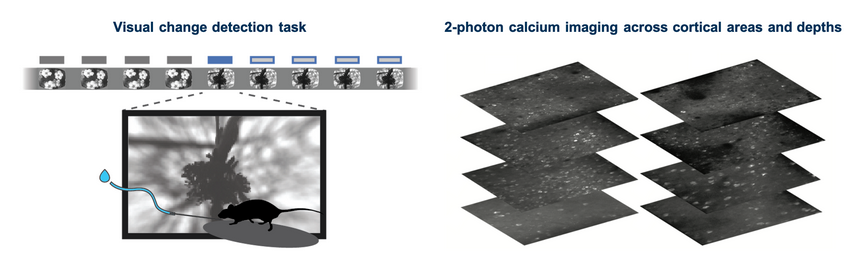

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

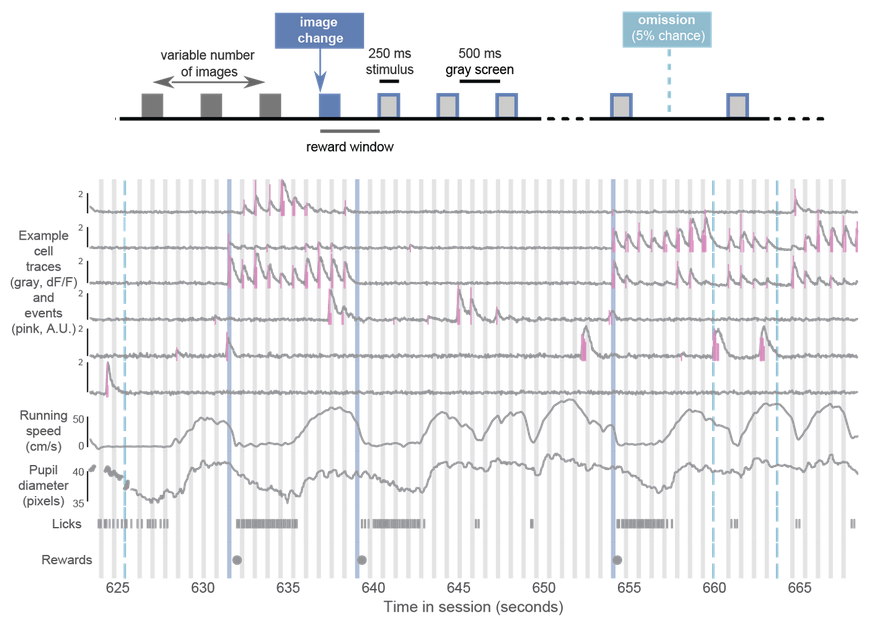

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [3]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    array2df(
        data,
        "stim_table",
        ["temporal_frequency", "orientation", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)
time_axis = data["t"]
dff_sequence = data["dff"]
stim_table = data["stim_table"]
stim_epoch_table = data["stim_epoch_table"]
roi_masks = data["roi_masks"]
max_projection = data["max_projection"]
running_speed = data["running_speed"]
stim_epoch_table = stim_epoch_table.rename(
    columns={"start": "stimulus", "end": "start", "stimulus": "end"}
)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



In [4]:
# print(data["stim_table"])
print(data["stim_epoch_table"])
# print(running_speed[1, :])
# plt.plot(running_speed[0, 800:1200])

                 start    end stimulus
0    drifting_gratings    747    18775
1  natural_movie_three  19709    37767
2    natural_movie_one  38671    47699
3    drifting_gratings  48602    66630
4          spontaneous  66780    75697
5  natural_movie_three  75698    93756
6    drifting_gratings  94659   115215


106: number of cells \
115471: frames \
628: number of stims\
5: property of stims, temporal frequency, orientation, blank sweep?, start, end\
512x512: size of image \
2: \
7: types of stims
||stimulus|start|end|
|---|---|---|---|
0|    drifting_gratings|    747|    18775|
1|  natural_movie_three|  19709|    37767|
2|    natural_movie_one|  38671|    47699|
3|    drifting_gratings|  48602|    66630|
4|          spontaneous|  66780|    75697|
5|  natural_movie_three|  75698|    93756|
6|    drifting_gratings|  94659|   115215|

3:

## Question

**Is there spatial structure in the preferred orientation/direction/spatial frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.

## 1. Preprocessing
**1.1. Downsample the data to ...** (not necessary, 30 Hz is not too high)\
**1.2. Signal correction to remove the artifact.** (bleaching has been removed)\
**1.3. Normalization** (Not necessary, dff is already normalized, z-score is not necessary)\
**1.4. Filter the index for drifting gratings**

In [5]:
def is_grating(idx):
    """
    Check if the stimulus is a grating
    """
    if idx <= 18775:
        return True
    if idx <= 66630 and idx >= 48602:
        return True
    if idx <= 115215 and idx >= 94659:
        return True
    return False


def axis_mapping(idx):
    """
    Map the orignial index to the index of the grating stimulus
    """
    if idx <= 18775:
        return idx
    if idx <= 66630:
        return idx - (18775 - 747)
    if idx <= 115215:
        return idx - (18775 - 747) - (66630 - 48602)


def plot_sample(t, dff, cell, sample=None):
    """
    Plot the sample time series of dff
    t: time axis
    dff: dff sequence
    cell: cell index
    sample: sample index
    """
    if sample is None:
        sample = range(len(t))
    plt.plot(t[sample], dff[cell, sample])
    plt.xlabel("Time (s)")
    plt.ylabel("DFF")
    plt.title(f"Cell {cell} - Sample {np.min(t[sample]), np.max(t[sample])}")
    plt.show()


def preprocess():
    # print(stim_epoch_table.iloc[0])
    grating_index = (
        list(range(stim_epoch_table.iloc[0][1], stim_epoch_table.iloc[0][2]))
        + list(range(stim_epoch_table.iloc[3][1], stim_epoch_table.iloc[3][2]))
        + list(range(stim_epoch_table.iloc[6][1], stim_epoch_table.iloc[6][2]))
    )
    grating_index = np.array(grating_index)
    grating_stim = []
    # browse through the grating stimulus in stim_table
    for i in range(len(stim_table)):
        if is_grating(stim_table.iloc[i][4]):
            # print(i, stim_table.iloc[i][4])
            grating_stim.append(i)
    grating_stim = np.array(grating_stim)
    return grating_index, grating_stim, np.std(dff_sequence[:, grating_index], axis=1)
    # print(grating_index)


grating_index, grating_stim, dff_std = preprocess()

### Plot sample calcium trace

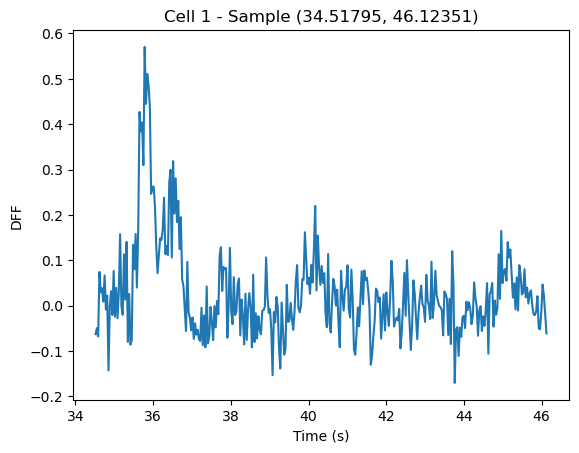

In [6]:
# plot_sample(time_axis, dff_sequence, 1, range(18000, 20000))
# plot_sample(time_axis, dff_sequence, 3, range(30000, 31000))
# print(grating_index[15000])
plot_sample(time_axis, dff_sequence, 1, grating_index[0:350])

## OASIS spike inference

From the AllenSDK website, we have the Calcium imaging is based on GCaMP6, and from the https://neuronline.sfn.org/-/media/Project/Neuronline/PDFs/2015/Engineering-Fluorescent-Calcium-Sensor-Proteins-for-Imaging-Neural-Activity_with_logo.pdf we have the **rise and decay time constant for GCaMP6 are 50 ms and 140 ms**.

In [7]:
from oasis.functions import (
    gen_data,
    gen_sinusoidal_data,
    deconvolve,
    estimate_parameters,
)
from oasis.plotting import simpleaxis
from oasis.oasis_methods import oasisAR1, oasisAR2


def oasis_deconv(time, dff, standard_deviation=1.0):
    if type(standard_deviation) is float:
        standard_deviation = np.ones(dff.shape[0], dtype=np.float64)
    rise_time = np.exp(-1 / (0.05 * 30), dtype=np.float64)
    decay_time = np.exp(-1 / (0.14 * 30), dtype=np.float64)
    g_1 = rise_time + decay_time
    g_2 = -rise_time * decay_time
    # print('g1=', g_1, 'g2=', g_2")
    print("g1=", g_1, "g2=", g_2)
    spikes = np.empty(dff.shape, dtype=np.float64)
    denoise = np.empty(dff.shape, dtype=np.float64)
    for i in range(dff.shape[0]):
        print(i, 1 * standard_deviation[i])
        %time denoise[i, :], spikes[i, :] = oasisAR2(dff[i, :].astype(np.float64), g_1, g_2, lam=0, s_min=1*standard_deviation[i])
        # s_min should not be a constant but the deviation of the signal
    return denoise, spikes


def plot_oasis_result(time, dff, denoise, spikes):
    fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    ax[0].plot(time, dff, label="dff")
    ax[0].plot(time, denoise, label="denoise")
    ax[0].legend()
    ax[1].plot(time, spikes, label="spikes")
    ax[1].legend()
    plt.show()


# print(grating_index.shape, dff_sequence.shape, dff_std.shape)
oasis_deconved_dff, oasis_spikes = oasis_deconv(time_axis, dff_sequence, dff_std)
# oasis_deconved_dff, oasis_spikes = oasis_deconv(
#     time_axis[grating_index], dff_sequence[grating_index], dff_std
# )

In [8]:
import pickle

# pickle.dump(
#     {"denoised": oasis_deconved_dff, "spikes": oasis_spikes},
#     open("./data/oasis_all_smin_1std_freq_30.pkl", "wb"),
# open("./data/oasis_gratings_smin_1std_freq_30.pkl", "wb")
# )
# a = pickle.load(open("./data/oasis_smin_0_5.pkl", "rb"))

In [84]:
# Omit it when don't want to use the saved data
stored_data = np.load("./data/oasis_all_smin_1std_freq_30.pkl", allow_pickle=True)
oasis_deconved_dff = stored_data["denoised"]
oasis_spikes = stored_data["spikes"]

### Plot sample calcium trace and deconved spike trace

range(4220, 5724)


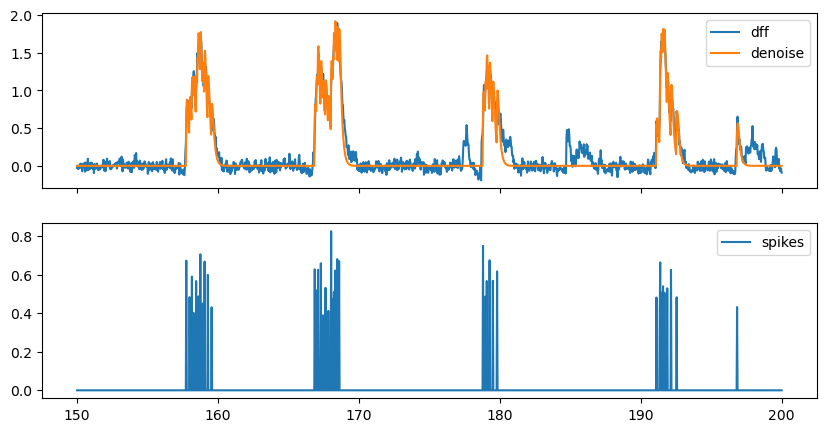

'\nplot_oasis_result(\n    # time_axis[2192:2282],\n    range(14742, 14801),\n    dff_sequence[2, 14742:14801],\n    oasis_deconved_dff[2, 14742:14801],\n    oasis_spikes[2, 14742:14801],\n)\n'

In [85]:
# print(np.argmax(time_axis > 500))
sample_time = range(np.argmax(time_axis > 150), np.argmax(time_axis > 200))
print(sample_time)
plot_oasis_result(
    time_axis[sample_time],
    dff_sequence[10, sample_time],
    oasis_deconved_dff[10, sample_time],
    oasis_spikes[10, sample_time],
)
"""
plot_oasis_result(
    # time_axis[2192:2282],
    range(14742, 14801),
    dff_sequence[2, 14742:14801],
    oasis_deconved_dff[2, 14742:14801],
    oasis_spikes[2, 14742:14801],
)
"""

## get spike count
for each stimulus type in each cell


In [87]:
def stim_mapping(stim_type, property):
    if stim_type == "direction":
        return int(property / 45)
    if stim_type == "temporal_frequency":
        return int(property)
    if stim_type == "orientation":
        return int((property + 90) / 45) % 4

In [88]:
# get spcount for each cell, each stimulus type
def get_spcount(time, spikes, stim_table):
    """
    Get the spike count for each cell, each stimulus type
    time: time axis
    spikes: spike sequence
    stim_table: stimulus table
    """
    spcount = np.zeros((spikes.shape[0], 3, 16, 200))
    cucount = np.zeros((3, 16), dtype=np.int32)
    # print(stim_table)
    length = len(stim_table)
    for i in range(length):
        index = i
        start = int(stim_table.iloc[index]["start"])
        end = int(stim_table.iloc[index]["end"])
        # PSTH.append(np.sum(spikes[:, start:end], axis=1) / (end - start))
        if stim_table.iloc[index]["blank_sweep"]:
            continue
        # print(index, start, end)
        # print(type(start), type(end))
        index_direction = stim_mapping(
            "direction", stim_table.iloc[index]["orientation"]
        )
        cucount[0, index_direction] += 1
        spcount[:, 0, index_direction, cucount[0, index_direction] - 1] = (
            np.sum(spikes[:, start:end], axis=1) / (end - start) * 30
        )

        index_freq = stim_mapping(
            "temporal_frequency", stim_table.iloc[index]["temporal_frequency"]
        )
        cucount[1, index_freq] += 1
        spcount[
            :,
            1,
            index_freq,
            cucount[1, index_freq] - 1,
        ] = (
            np.sum(spikes[:, start:end], axis=1) / (end - start) * 30
        )

        index_orientation = stim_mapping(
            "orientation", stim_table.iloc[index]["orientation"]
        )
        cucount[2, index_orientation] += 1
        spcount[:, 2, index_orientation, cucount[2, index_orientation] - 1] = (
            np.sum(spikes[:, start:end], axis=1) / (end - start) * 30
        )
    cucount = np.maximum(cucount, 1)
    # spcount = spcount / cucount
    # print(cucount[0])
    return spcount, cucount


# print(stim_table.iloc[grating_stim])
spcount, cucount = get_spcount(time_axis, oasis_spikes, stim_table.iloc[grating_stim])

### Plot spike counts for sample cell

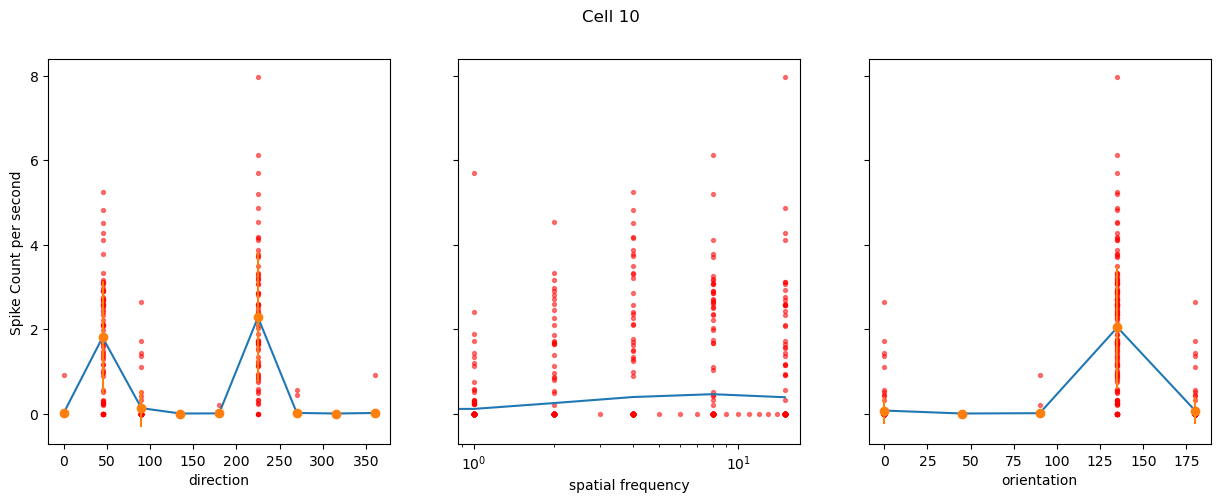

In [117]:
# plot sample spcount for a cell
def vector_std(arr, length):
    ret = np.zeros(length.shape[0])
    for i in range(length.shape[0]):
        ret[i] = np.std(arr[i, : length[i]])
        # print(np.mean(arr[i, : length[i]]), ret[i])
    return ret


def vector_scatter(arr, length, const, ax):
    # print(length)
    for i in range(length.shape[0]):
        ax.scatter(
            np.ones(length[i]) * i * const, arr[i, : length[i]], c="r", s=8, alpha=0.5
        )
    return ax


def plot_spcount(cell, spcount, cucount):
    """
    Plot the spcount for a cell
    cell: cell index
    spcount: spcount
    stim_type: stimulus type
    """
    # print(spcount[cell, :, :8].shape, spcount[cell, :, np.newaxis, 0].shape)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    cyclic_count = np.concatenate(
        (
            spcount[cell, :, :8],
            spcount[cell, :, np.newaxis, 0],
        ),
        axis=1,
    )
    # print(cyclic_count[0, 3])
    axis_count = np.concatenate(
        (
            cucount[0, :8],
            cucount[0, 0][np.newaxis],
        ),
    )
    ax[0].plot(
        np.linspace(0, 360, 9),
        np.sum(cyclic_count[0, :], axis=-1) / axis_count,
    )
    vector_scatter(
        cyclic_count[0, :],
        axis_count,
        45,
        ax[0],
    )
    ax[0].errorbar(
        np.linspace(0, 360, 9),
        np.sum(cyclic_count[0, :], axis=-1) / axis_count,
        yerr=vector_std(
            cyclic_count[0, :],
            axis_count,
        ),
        fmt="o",
    )
    ax[0].set_xlabel("direction")
    ax[0].set_ylabel("Spike Count per second")
    ax[1].semilogx(
        np.array([0, 1, 2, 4, 8, 15]),
        np.mean(spcount[cell, 1, (0, 1, 2, 4, 8, 15)], axis=-1),
    )
    # ax[1].set_semilogx()
    vector_scatter(
        spcount[cell, 1, :16],
        cucount[1, :16],
        1,
        ax[1],
    )
    ax[1].set_xlabel("spatial frequency")
    # ax[1].ylabel("Spike Count")
    cyclic_count = np.concatenate(
        (
            spcount[cell, :, :4],
            spcount[cell, :, np.newaxis, 0],
        ),
        axis=1,
    )
    axis_count = np.concatenate(
        (
            cucount[2, :4],
            cucount[2, 0][np.newaxis],
        ),
    )
    ax[2].plot(
        np.linspace(0, 180, 5),
        cyclic_count[2, :].sum(axis=-1) / axis_count,
    )
    vector_scatter(
        cyclic_count[2, :],
        axis_count,
        45,
        ax[2],
    )
    ax[2].errorbar(
        np.linspace(0, 180, 5),
        cyclic_count[2, :].sum(axis=-1) / axis_count,
        yerr=vector_std(
            cyclic_count[2, :],
            axis_count,
        ),
        fmt="o",
    )
    ax[2].set_xlabel("orientation")
    # ax[2].ylabel("Spike Count")
    # fig.set_title(f"Cell {cell} - Stimulus {stim_type}")
    # fig.tight_layout()
    fig.suptitle(f"Cell {cell}")


# print(grating_stim)
# print(spcount[2, 0, 0, : cucount[0, 1]])
plot_spcount(10, spcount, cucount)

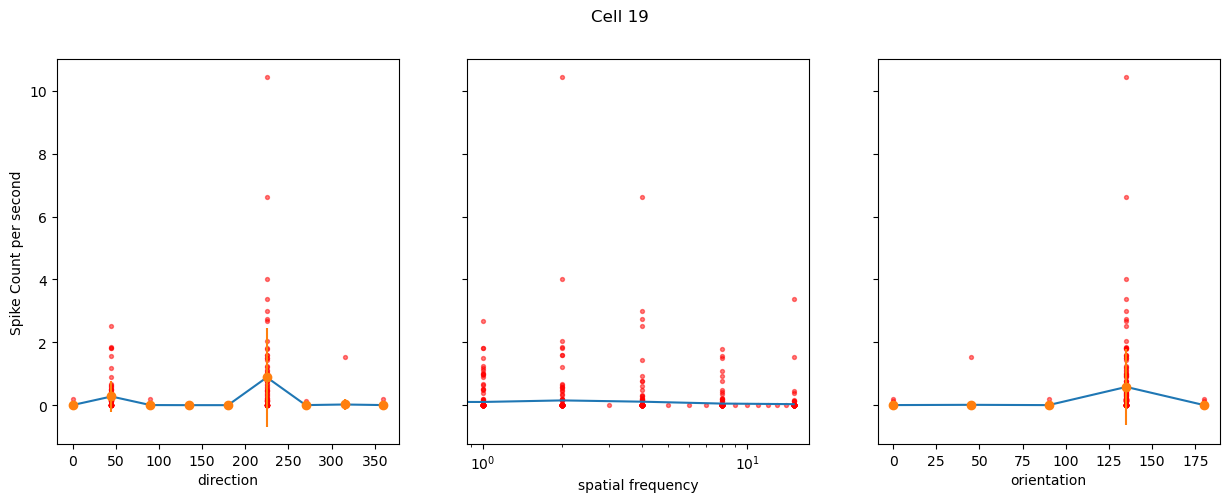

In [118]:
plot_spcount(19, spcount, cucount)

## Curve fitting

### Direction/Orientation fitting
Using Von-Mises function to fit the spcount

In [92]:
def vonMises(θ, α, κ, ν, ϕ):
    """Evaluate the parametric von Mises tuning curve with parameters p at locations theta.

    Parameters
    ----------

    θ: np.array, shape=(N, )
        Locations. The input unit is degree.

    α, κ, ν, ϕ : float
        Function parameters

    Return
    ------
    f: np.array, shape=(N, )
        Tuning curve.
    """

    # insert your code here

    # -----------------------------------
    # Implement the Mises model (0.5 pts)
    # -----------------------------------
    f = np.exp(
        α + κ * (np.cos(2 * np.deg2rad(θ - ϕ)) - 1) + ν * np.cos(np.deg2rad(θ - ϕ) - 1)
    )
    return f

In [113]:
def tuning_curve(counts, trials, dirs, neuron, show=True):
    """Fit a von Mises tuning curve to the spike counts in count with direction dir using a least-squares fit.

    Parameters
    ----------
    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    show: bool, default=True
        Plot or not.

    Return
    ------
    p: np.array or list, (4,)
        parameter vector of tuning curve function
    """
    # dirs = dirs.reshape(nDirs, -1)
    # counts = counts.reshape(nDirs, -1)
    p = np.zeros((4,))
    # print(counts.sum(axis=-1), trials)
    # print(dirs, counts.sum(axis=-1) / trials)
    p, _ = opt.curve_fit(vonMises, dirs, counts.sum(axis=-1) / trials)
    if show == True:
        fig, ax = plt.subplots(figsize=(7, 5))
        # ax.plot(dirs.sum(axis=1) / nTrials, counts.sum(axis=1) / nTrials, "o")
        for i in range(len(dirs)):
            ax.scatter(
                dirs[i].repeat(trials[i]),
                counts[i, : trials[i]],
                s=10,
                color="k",
                alpha=0.2,
            )
        ax.errorbar(
            dirs, counts.sum(axis=-1) / trials, yerr=vector_std(counts, trials), fmt="o"
        )
        ax.plot(np.arange(0, 360, 1), vonMises(np.arange(0, 360, 1), *p))
        ax.set_xlabel("Direction (degree)")
        ax.set_ylabel("Spikes per second")
        ax.set_title("Direction selectivity tuning curve of neuron {}".format(neuron))
        return p
    else:
        return p

### Plot direction/orientation curve fitting results for sample cells

array([ 0.76468556,  4.44620696, -0.24406647, 49.62531192])

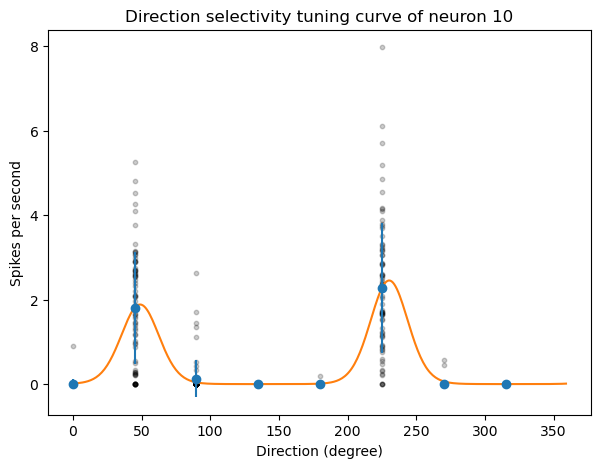

In [114]:
tuning_curve(spcount[10, 0, :8], cucount[0, :8], np.linspace(0, 360, 9)[:-1], 10)

array([-3.7818455 ,  1.63106369,  0.44668408,  0.0594352 ])

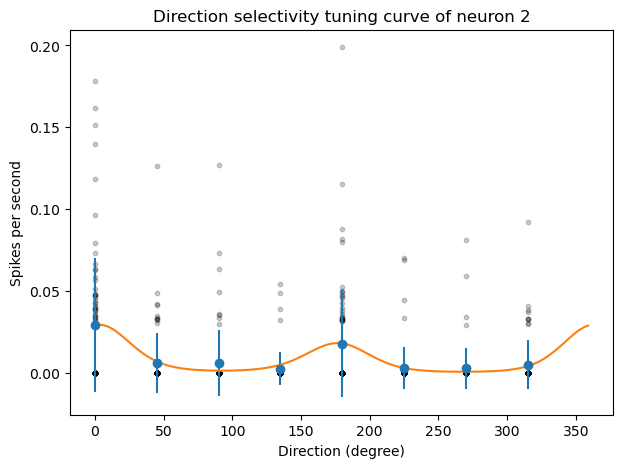

In [115]:
tuning_curve(spcount[2, 0, :8], cucount[0, :8], np.linspace(0, 360, 9)[:-1], 2)

array([-0.69950088,  6.17548839, -1.04055716, 43.65421184])

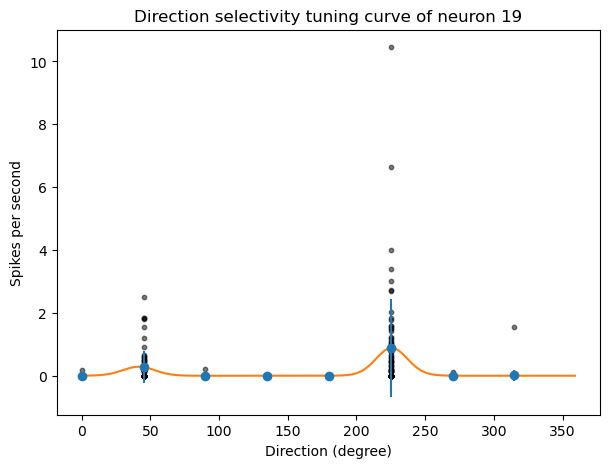

In [96]:
tuning_curve(spcount[19, 0, :8], cucount[0, :8], np.linspace(0, 360, 9)[:-1], 19)

### Frequency furve fitting
Apply asymmetric Gaussian model to fit the curve, which is the common choice for neuroscientist.

Reference: https://www.nature.com/articles/s41467-020-19954-9#code-availability

In [97]:
from scipy.special import erf


def asymGaussian(x, a, mu, sigma, gamma):
    amp = a / (sigma * np.sqrt(2 * np.pi))
    spread = np.exp((-((x - mu) ** 2.0)) / (2 * sigma**2.0))
    skew = 1 + erf((gamma * (x - mu)) / (sigma * np.sqrt(2)))
    return amp * spread * skew


def asy_curve_fitting(counts, trials, dirs, neuron, show=True):
    """
    Fit the data with an asymmetric Gaussian.
    counts: number of spikes for each frequency
    trials: number of trials for each frequency
    dirs: frequency
    show: whether to show the plot
    """
    p, _ = opt.curve_fit(asymGaussian, dirs, counts.sum(axis=1) / trials, maxfev=100000)
    if show == True:
        fig, ax = plt.subplots(figsize=(7, 5))
        # ax.plot(dirs.sum(axis=1) / nTrials, counts.sum(axis=1) / nTrials, "o")
        for i in range(len(dirs)):
            ax.scatter(
                dirs[i].repeat(trials[i]),
                counts[i, : trials[i]],
                s=10,
                color="k",
                alpha=0.5,
            )
        ax.errorbar(
            dirs, counts.sum(axis=-1) / trials, yerr=vector_std(counts, trials), fmt="o"
        )
        ax.semilogx(
            np.logspace(-2, 4, 48, base=2),
            asymGaussian(np.logspace(-2, 4, 48, base=2), *p),
        )
        ax.set_ylim(-0.1, 3 * counts.sum(axis=-1).max() / trials.max())
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Spikes per second")
        ax.set_title("Frequency tuning curve for neuron {}".format(neuron))
        return p
    else:
        return p

### Plot frequency tuning curve fitting result for sample cells

array([ 1.53960285,  0.82625711,  5.02435622, 14.81848237])

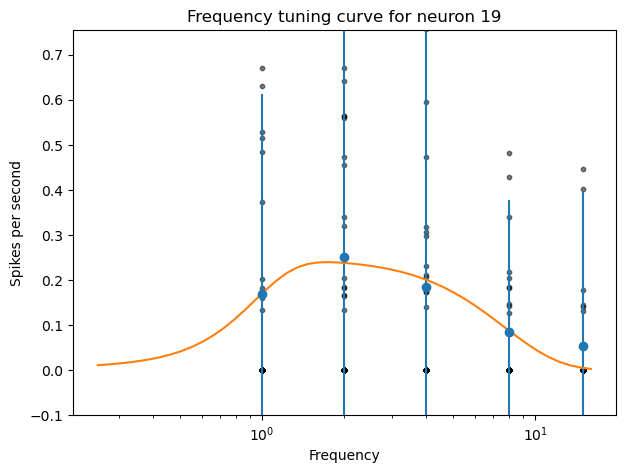

In [98]:
asy_curve_fitting(
    spcount[19, 1, (0, 1, 2, 4, 8, 15)],
    cucount[1, (0, 1, 2, 4, 8, 15)],
    np.array([0, 1, 2, 4, 8, 15]),
    19,
)

array([ 1.7281835 ,  6.28756313, 12.25898746,  2.8115726 ])

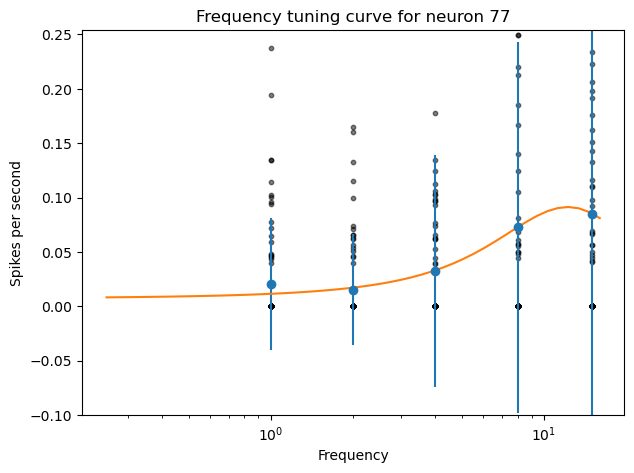

In [99]:
asy_curve_fitting(
    spcount[77, 1, (0, 1, 2, 4, 8, 15)],
    cucount[1, (0, 1, 2, 4, 8, 15)],
    np.array([0, 1, 2, 4, 8, 15]),
    77,
)

## Question
For each cell, each direction and each frequency, there is a large amount of zero spike response, which is different from hw4.

Does it mean that a cell has a certain probability (not small) not to fire even when the stimulus is in its preference.

## Statistical testing


### Direction/Orientation selectivity testing
Apply permutation test for tuning curve fitting, and find direction/orientation sensitive cells.

In [100]:
def test_tuning(counts, trials, dirs, psi=1, niters=1000, show=False, neuron=0):
    """Plot the data if show is True, otherwise just return the fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    psi: int
        fourier component to test (1 = direction, 2 = orientation)

    niters: int
        Number of iterations / permutation

    show: bool
        Plot or not.

    Returns
    -------
    p: float
        p-value
    q: float
        magnitude of second Fourier component

    qdistr: np.array
        sampling distribution of |q| under the null hypothesis

    """

    def permute(counts, trials):
        pp = np.zeros(0)
        for i in range(len(counts)):
            pp = np.append(pp, counts[i, : trials[i]].copy())
        pp = pp.flatten()
        # print(pp.shape)
        pp = np.random.permutation(pp)
        ret = np.zeros(counts.shape)
        for i in range(len(counts)):
            ret[i, : trials[i]] = pp[: trials[i]]
            pp = pp[trials[i] :]
        return ret

    m = counts.sum(axis=1) / trials
    q = (m * np.exp(1j * psi * np.deg2rad(dirs))).sum()
    nu = counts.copy()
    qdistr = np.zeros((niters,), dtype=complex)
    # print(trials * np.exp(1j * psi * np.deg2rad(dirs)))
    # print(m)
    for i in range(niters):
        # nu = np.random.permutation(counts.flatten()).reshape(len(dirs), -1)
        nu = permute(counts, trials)
        # print(nu.sum(axis=1) / trials)
        qdistr[i] = (
            nu.sum(axis=1) / trials * np.exp(1j * psi * np.deg2rad(dirs))
        ).sum()
    # print(qdistr)
    qdistr = np.abs(qdistr)
    p = np.sum(np.abs(qdistr) > np.abs(q)) / niters
    if show == True:
        # print(p, q, qdistr)
        fig, ax = plt.subplots(figsize=(7, 4))
        # you can use sns.histplot for the histogram
        sns.histplot(qdistr, ax=ax, bins=40)
        ax.axvline(np.abs(q), color="r")
        ax.set_xlabel("q")
        ax.set_ylabel("Count")
        if psi == 1:
            ax.set_title(
                "Permutation test for direction selectivity of neuron " + str(neuron)
            )
        elif psi == 2:
            ax.set_title(
                "Permutation test for orientation selectivity of neuron " + str(neuron)
            )
        plt.show()
    else:
        return p, q, qdistr

### Plot Permutation test result for sample cells

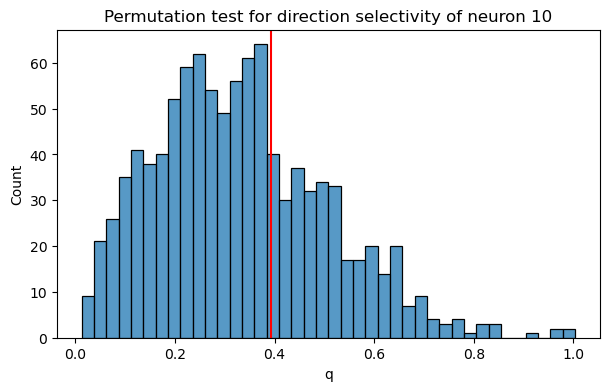

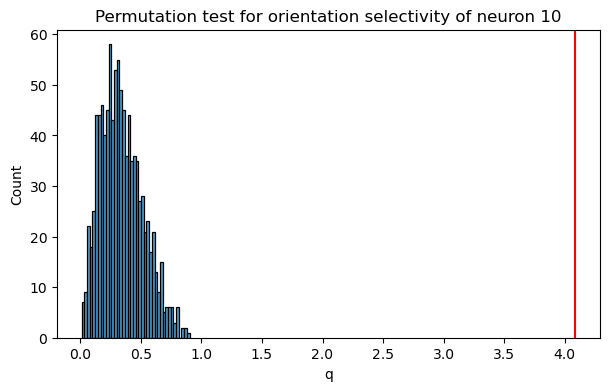

In [101]:
test_tuning(
    spcount[10, 0, :8],
    cucount[0, :8],
    np.linspace(0, 360, 9)[:-1],
    1,
    show=True,
    neuron=10,
)
test_tuning(
    spcount[10, 0, :8],
    cucount[0, :8],
    np.linspace(0, 360, 9)[:-1],
    2,
    show=True,
    neuron=10,
)

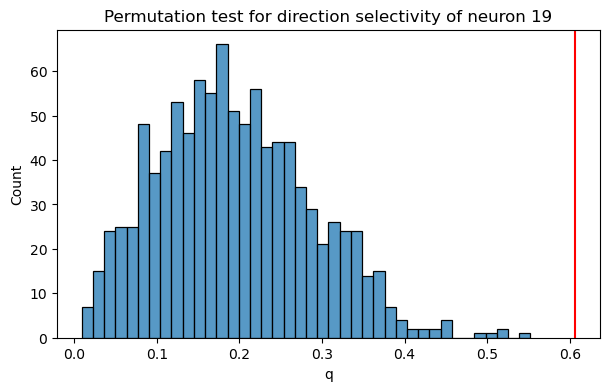

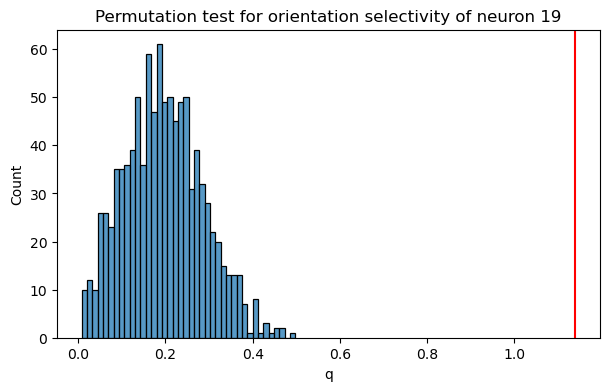

In [102]:
test_tuning(
    spcount[19, 0, :8],
    cucount[0, :8],
    np.linspace(0, 360, 9)[:-1],
    1,
    show=True,
    neuron=19,
)
test_tuning(
    spcount[19, 0, :8],
    cucount[0, :8],
    np.linspace(0, 360, 9)[:-1],
    2,
    show=True,
    neuron=19,
)

In [103]:
direction_selective = []
orientation_selective = []
p_direction = []
p_orientation = []
# collect p values for orientation / direction selectivity
for psi in range(2):
    for neuron in range(spcount.shape[0]):
        dirs = np.linspace(0, 360, 9)[:-1]
        p, q, qdistr = test_tuning(
            spcount[neuron, 0, :8], cucount[0, :8], dirs, psi=psi + 1, show=False
        )
        if p < 0.01:
            if psi == 0:
                direction_selective.append(neuron)
                p_direction.append(p)
            else:
                orientation_selective.append(neuron)
                p_orientation.append(p)
        print(
            "Neuron %d is %s selective (p = %.3f)"
            % (neuron, ["direction", "orientation"][psi], p)
        )

Neuron 0 is direction selective (p = 0.174)
Neuron 1 is direction selective (p = 0.965)
Neuron 2 is direction selective (p = 0.012)
Neuron 3 is direction selective (p = 0.746)
Neuron 4 is direction selective (p = 0.052)
Neuron 5 is direction selective (p = 0.000)
Neuron 6 is direction selective (p = 0.041)
Neuron 7 is direction selective (p = 0.955)
Neuron 8 is direction selective (p = 0.660)
Neuron 9 is direction selective (p = 0.379)
Neuron 10 is direction selective (p = 0.352)
Neuron 11 is direction selective (p = 0.988)
Neuron 12 is direction selective (p = 0.334)
Neuron 13 is direction selective (p = 0.280)
Neuron 14 is direction selective (p = 0.325)
Neuron 15 is direction selective (p = 0.329)
Neuron 16 is direction selective (p = 0.533)
Neuron 17 is direction selective (p = 0.455)
Neuron 18 is direction selective (p = 0.864)
Neuron 19 is direction selective (p = 0.000)
Neuron 20 is direction selective (p = 0.018)
Neuron 21 is direction selective (p = 0.186)
Neuron 22 is directi

In [105]:
print(len(direction_selective), "\n", direction_selective)

12 
 [5, 19, 27, 51, 55, 58, 64, 70, 78, 97, 99, 102]


In [106]:
print(len(orientation_selective), "\n", orientation_selective)

42 
 [0, 2, 5, 6, 7, 10, 11, 18, 19, 21, 29, 30, 31, 33, 34, 42, 43, 44, 46, 48, 50, 51, 53, 54, 55, 61, 64, 65, 69, 70, 75, 77, 78, 84, 89, 91, 95, 96, 97, 99, 100, 102]


### Kruskal Wallis test for frequency
The Kruskal test measures the spike response distribution at each frequency, and test if they are generated from the same distribution.

In [107]:
freq_selective = []
p_freq = []
for neuron in range(spcount.shape[0]):
    stats, p = kruskal(
        spcount[neuron, 1, 1],
        spcount[neuron, 1, 2],
        spcount[neuron, 1, 4],
        spcount[neuron, 1, 8],
        spcount[neuron, 1, 15],
    )
    if p < 0.01:
        freq_selective.append(neuron)
        p_freq.append(p)
    print("Neuron %d is frequency selective (p = %.3f)" % (neuron, p))
print(len(freq_selective), "\n", freq_selective)

Neuron 0 is frequency selective (p = 0.092)
Neuron 1 is frequency selective (p = 0.992)
Neuron 2 is frequency selective (p = 0.632)
Neuron 3 is frequency selective (p = 0.017)
Neuron 4 is frequency selective (p = 0.007)
Neuron 5 is frequency selective (p = 0.001)
Neuron 6 is frequency selective (p = 0.842)
Neuron 7 is frequency selective (p = 0.698)
Neuron 8 is frequency selective (p = 0.052)
Neuron 9 is frequency selective (p = 0.001)
Neuron 10 is frequency selective (p = 0.091)
Neuron 11 is frequency selective (p = 0.044)
Neuron 12 is frequency selective (p = 0.001)
Neuron 13 is frequency selective (p = 0.226)
Neuron 14 is frequency selective (p = 0.000)
Neuron 15 is frequency selective (p = 0.495)
Neuron 16 is frequency selective (p = 0.019)
Neuron 17 is frequency selective (p = 0.000)
Neuron 18 is frequency selective (p = 0.000)
Neuron 19 is frequency selective (p = 0.043)
Neuron 20 is frequency selective (p = 0.000)
Neuron 21 is frequency selective (p = 0.117)
Neuron 22 is frequen

## Plot spatial structures of direction/orientation selective cells


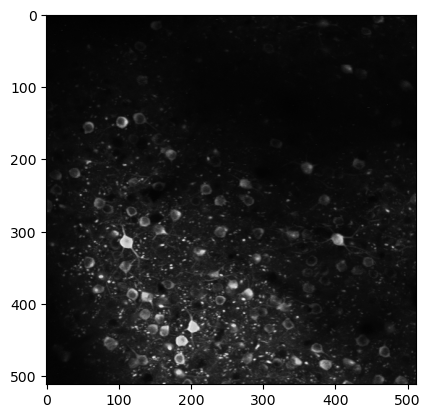

In [108]:
# Plot the max projection
plt.imshow(max_projection, cmap="gray")
# print(max_projection.max())

In [109]:
# assign red color to direction selevtive cell and plot them in roi masks, the intensity of the color is proportional to the p value
def plot_roi(selectivity, p, roi_masks, whole_image=max_projection, title=None):
    whole_image = whole_image / whole_image.max()
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    max_signal = np.repeat(whole_image[:, :, np.newaxis], 3, axis=-1)
    whole_image = max_signal.copy()
    # ax.imshow(max_projection)
    for i in range(len(selectivity)):
        # mask = np.flip(np.flip(roi_masks[selectivity[i]], axis=1).T, axis=1)
        mask = roi_masks[selectivity[i]]
        whole_image[mask == 1] = (
            np.array([1, 0, 0]) * (1 - p[i]) * max_signal[mask == 1]
        )

    ax[0].imshow(whole_image)
    ax[1].imshow(max_signal)
    fig.suptitle(title)
    plt.show()

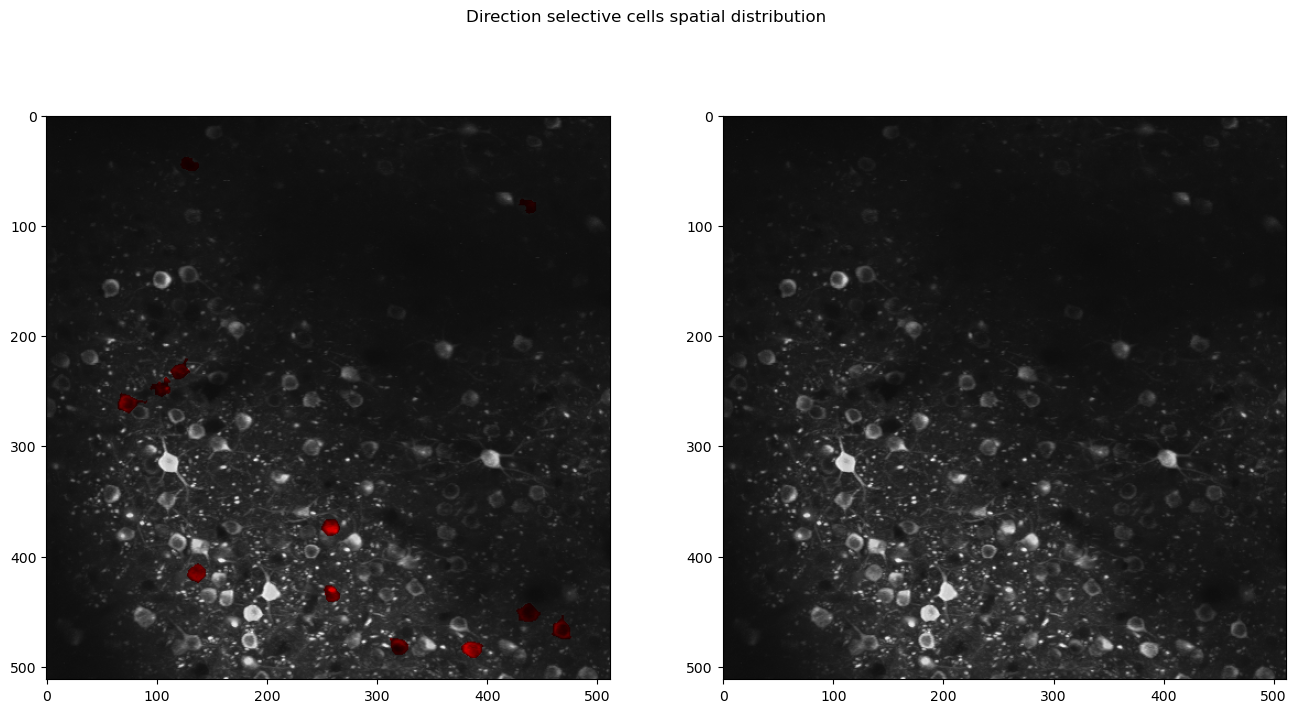

In [110]:
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(roi_masks[19].T, cmap="gray")
# plot_roi(range(0, 105), np.ones((105)) * 0.05, roi_masks, max_projection)
plot_roi(
    direction_selective,
    p_direction,
    roi_masks,
    max_projection,
    "Direction selective cells spatial distribution",
)

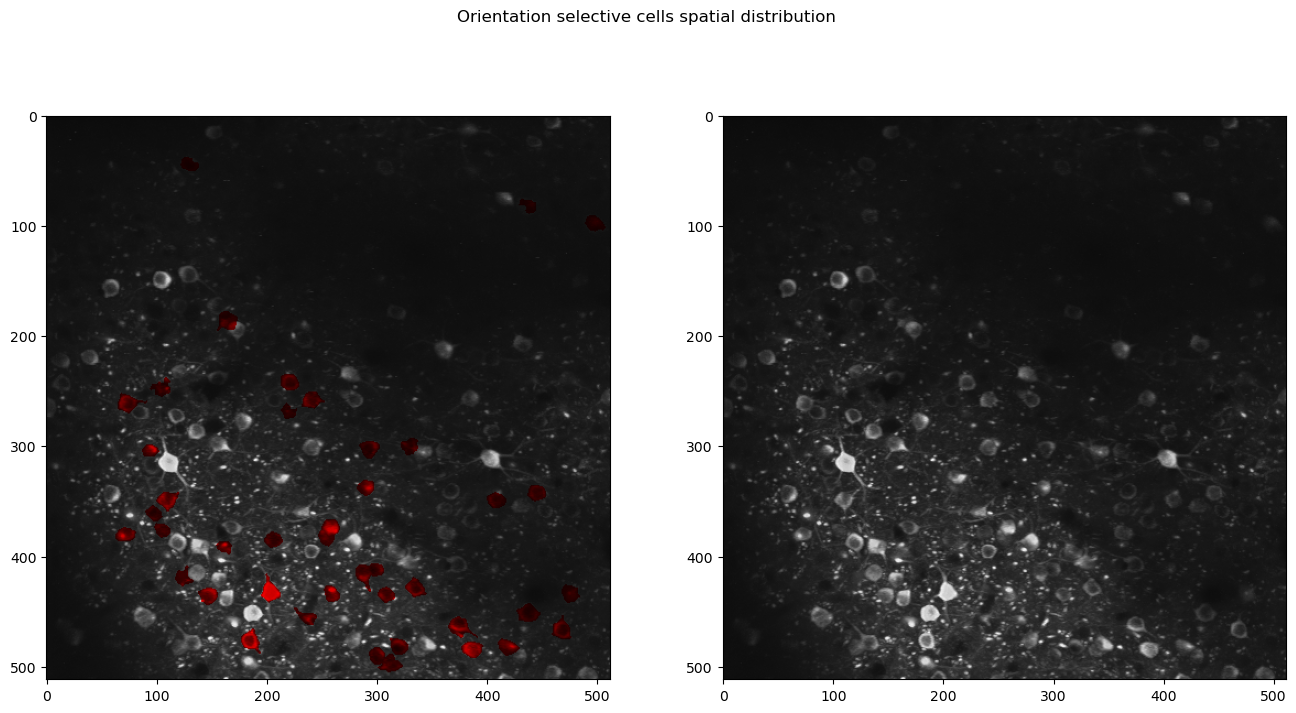

In [112]:
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(roi_masks[19].T, cmap="gray")
# plot_roi(range(0, 105), np.ones((105)) * 0.05, roi_masks, max_projection)
plot_roi(
    orientation_selective,
    p_orientation,
    roi_masks,
    max_projection,
    "Orientation selective cells spatial distribution",
)

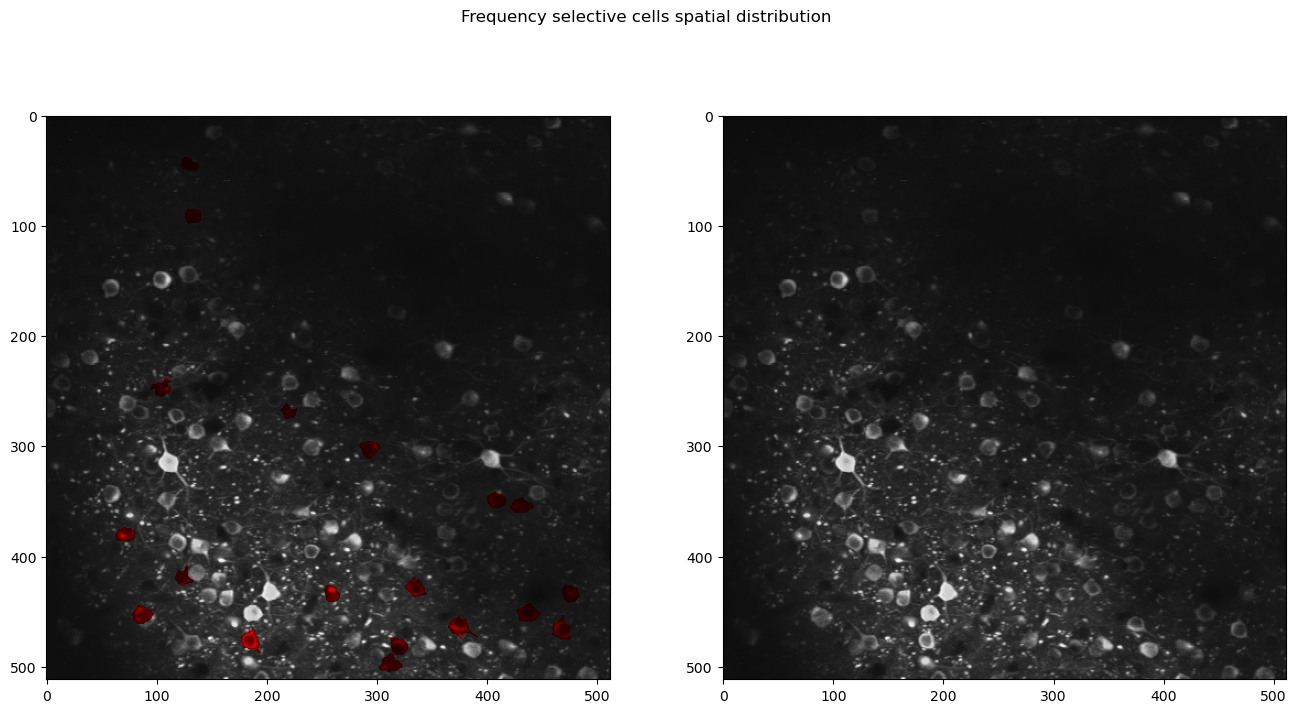

In [75]:
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(roi_masks[19].T, cmap="gray")
# plot_roi(range(0, 105), np.ones((105)) * 0.05, roi_masks, max_projection)
plot_roi(
    freq_selective,
    p_freq,
    roi_masks,
    max_projection,
    "Frequency selective cells spatial distribution",
)